# 6. Sonuç Analizi ve Raporlama

Bu notebook'ta tüm analizlerin sonuçlarını derleyip kapsamlı görselleştirmeler ve raporlar oluşturacağız:
1. Confusion Matrix
2. ROC Curve ve AUC
3. Precision-Recall Curve
4. Classification Report
5. Model Hata Analizi
6. Genel Sonuçlar ve Öneriler

## 6.1. Kütüphanelerin İmport Edilmesi

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, 
    roc_curve, precision_recall_curve, average_precision_score
)
from datetime import datetime

sns.set_style('whitegrid')  # Matplotlib yerine Seaborn ile stil ayarla
%matplotlib inline



## 6.2. Veri Setini Yükle ve Özellik/Hedef Ayrımı

In [17]:
# Veri setini yükle
df = pd.read_csv('../data/cardio_cleaned.csv')

# Sütunları belirle
# Özellik ve hedef değişkenleri ayır
# Önceden çıkardığın sütunları artık model için geri ekliyoruz
columns_to_drop = []  # artık hiçbir sütun düşürmüyoruz
features = [col for col in df.columns if col not in ['cardio'] + columns_to_drop]

X = df[features]
y = df['cardio']


X.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_years,bmi,pulse_pressure
0,18393,1,168,62.0,110,80,1,1,0,0,1,50,21.967120,30
1,20228,0,156,85.0,140,90,3,1,0,0,1,55,34.927679,50
2,18857,0,165,64.0,130,70,3,1,0,0,0,52,23.507805,60
3,17623,1,169,82.0,150,100,1,1,0,0,1,48,28.710479,50
4,17474,0,156,56.0,100,60,1,1,0,0,0,48,23.011177,40


## 6.3. Train-Test Split ve Scaling

In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 6.4. Model Yükleme

In [ ]:
# En iyi modeli yükle
try:
    with open('../models/best_model_optimized.pkl', 'rb') as f:
        model = pickle.load(f)
except:
    with open('../models/best_model.pkl', 'rb') as f:
        model = pickle.load(f)

model_name = type(model).__name__
print(f"Model yüklendi: {model_name}")

Model yüklendi: GradientBoostingClassifier


## 6.5. Tahmin Yapma

In [20]:
# Modelin türüne göre tahmin
if 'SVC' in model_name or 'Logistic' in model_name:
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
else:
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]


## 6.6. Confusion Matrix Görselleştirme

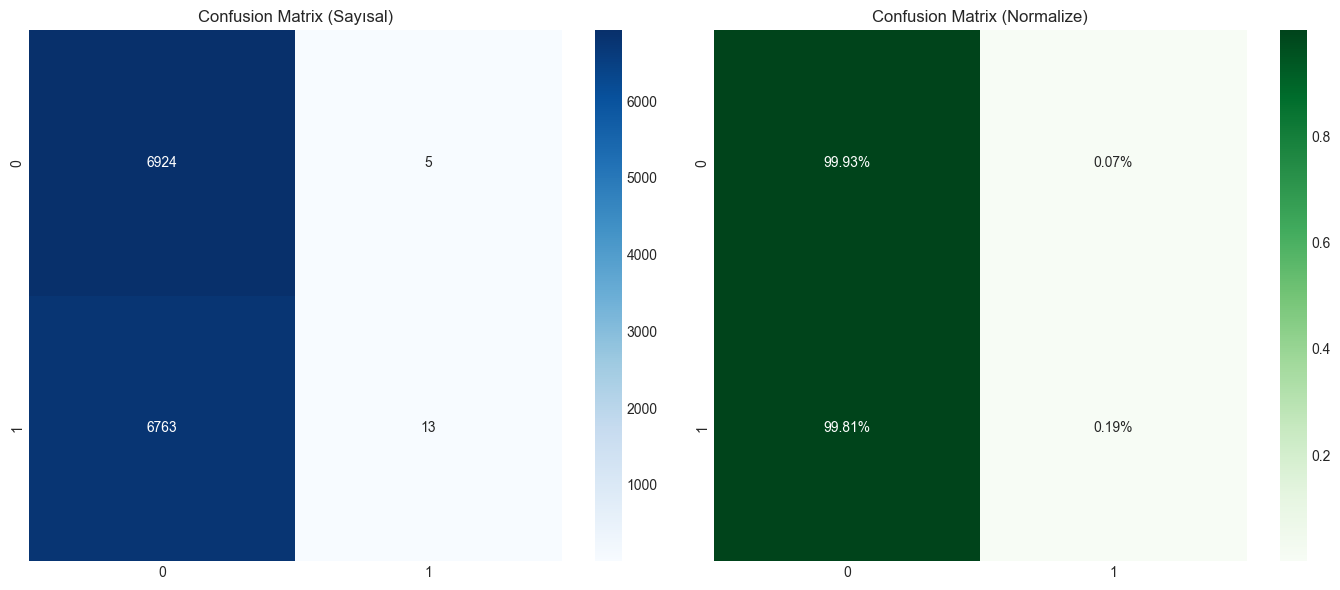

In [21]:
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1, 2, figsize=(14,6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Sayısal)')

sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalize)')

plt.tight_layout()
plt.show()

## 6.7. ROC Eğrisi

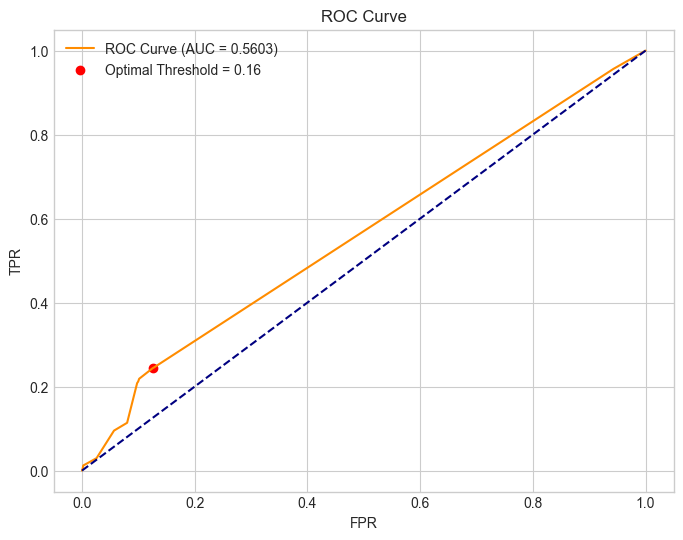

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='darkorange')
plt.plot([0,1], [0,1], '--', color='navy')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.show()

## 6.8. Precision-Recall Eğrisi

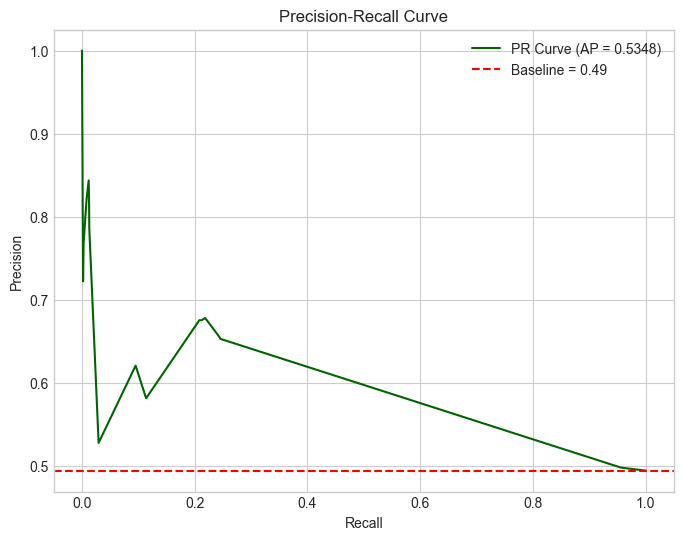

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)
baseline = y_test.mean()

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'PR Curve (AP = {avg_precision:.4f})', color='darkgreen')
plt.axhline(y=baseline, color='red', linestyle='--', label=f'Baseline = {baseline:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

## 6.9. Classification Report ve Özet Metrikler

In [25]:
print(classification_report(y_test, y_pred, target_names=['Sağlıklı (0)', 'Hasta (1)']))

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc,
    'Average Precision': avg_precision
}

metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metrik', 'Değer'])
metrics_df

              precision    recall  f1-score   support

Sağlıklı (0)       0.51      1.00      0.67      6929
   Hasta (1)       0.72      0.00      0.00      6776

    accuracy                           0.51     13705
   macro avg       0.61      0.50      0.34     13705
weighted avg       0.61      0.51      0.34     13705



,Metrik,Değer
0,Accuracy,0.506166
1,Precision,0.722222
2,Recall,0.001919
3,F1-Score,0.003827
4,ROC-AUC,0.560333
5,Average Precision,0.534754


## 6.10. Yanlış Tahminler ve Hata Analizi

In [ ]:
X_test_copy = X_test.copy()
X_test_copy['Gerçek'] = y_test
X_test_copy['Tahmin'] = y_pred
X_test_copy['Olasılık'] = y_proba
X_test_copy['Doğru_mu'] = X_test_copy['Gerçek'] == X_test_copy['Tahmin']

false_preds = X_test_copy[X_test_copy['Doğru_mu']==False]

print(f"Toplam yanlış tahmin: {len(false_preds)} ({len(false_preds)/len(X_test_copy)*100:.2f}%)")


Toplam yanlış tahmin: 6768 (49.38%)
